# Übung 8: Generative adversarial networks

Generative adversarial networks (GANs) lernen implizit ein generatives Modell von einer gegebenen Datendistribution. Dies geschieht durch ein Nullsummenspiel zwischen zwei neuronalen Netzwerken: Ein Generatornetzwerk versucht eine Funktion zu lernen, die Zufallsdaten aus einer einfachen parametrischen Verteilung in Bilder überführt, die von dem zweiten Netzwerk, dem Diskriminator, nicht von echten Bildern zu unterscheiden sind. Der Diskriminator ist ein Classifier, der darauf trainiert wird, echte Bilder von solchen zu unterscheiden, die der Generator generiert.

In dieser Übung sollst du ein GAN für den MNIST Datensatz implementieren.

## MNIST

Laden den MNIST Datensatz und plotte ein paar der Datenpunkte als Bilder. Du kannst das Keras modul ```keras.datasets``` benutzen, um die Daten automatisch herunterzuladen und einzulesen.

In [2]:
%matplotlib inline


import matplotlib.pyplot as plt

import os
#os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np

from keras.layers import BatchNormalization, Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam

from keras import initializers
import numpy as np

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


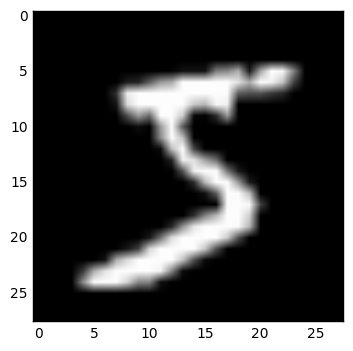

In [32]:
(X_train, _), (_, _) = mnist.load_data()
plt.imshow(X_train[0], cmap=plt.cm.gray)

In [33]:
# bringe den Datensatz in die Form, dass immer 1,28,28 vorliegt
X_train = (X_train.astype(np.float32) - 255/2)/255/2
X_train = X_train[:, np.newaxis, :, :]

In [34]:
X_train.shape

(60000, 1, 28, 28)

## Generator

Erstelle nun zuerst ein Model, welches aus einem Tensor mit den Dimensionen ```[batch_size, z_dim]``` einen Tensor mit den Dimensionen ```[batch_size, 28, 28, 1]``` generiert. ```28x28``` ist hierbei die Bildgröße der MNIST Daten, die Größe des Noisevektors (```z_dim```) kannst du selbst wählen. 

Sample nun eine Batch von Zufallswerten, z.b. aus einer Normalverteilung, und erstelle mit dem untrainierten Generator ein Batch von Bildern. Plotte diese generierten Bilder.

In [20]:
def plot_imgs(generator,noise):
    r, c = 5, 5
    #noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)
    print(gen_imgs.shape)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,0, :,:], cmap='gray') # hier habe ich was geändert
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

In [6]:
z_dim = 100
batch_size = 64
img_rows = 28
img_cols = 28
channels = 1

In [7]:
adam = Adam(lr=0.0002, beta_1=0.9)

In [8]:
# wir bauen unser eigenes netzwerk zum GAN

# Erstelle das Generator Netzwerk
# das muss irgendwie upsamplen und von der z_dim auf etwas kommen
generator = Sequential()

generator.add(Dense(200*14*14, input_dim=z_dim, kernel_initializer=initializers.glorot_normal(seed=None)))
generator.add(BatchNormalization())
generator.add(Activation('relu'))


generator.add(Reshape( [200, 14, 14] ))

# mache den random noise vektor jetzt größer auf 28 dimension
generator.add(UpSampling2D(size=(2, 2),data_format='channels_first'))

# füge konvolution hinzu
generator.add(Conv2D(100, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_uniform',data_format='channels_first'))
generator.add(BatchNormalization())
generator.add(Activation('relu'))


# jetzt reduziere die tiefe
generator.add(Conv2D(1, kernel_size=(1, 1), padding='same', kernel_initializer='glorot_uniform',data_format='channels_first'))
generator.add(Activation('sigmoid'))



generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 39200)             3959200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 39200)             156800    
_________________________________________________________________
activation_1 (Activation)    (None, 39200)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 200, 14, 14)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 200, 28, 28)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 28, 28)       180100    
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 28, 28)       112       
__________

In [14]:
noise = np.random.normal(0, 1, (batch_size, z_dim))

(64, 1, 28, 28)


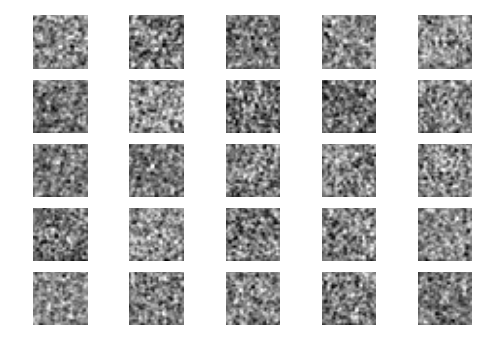

In [19]:
plot_imgs(generator, noise)

## Discriminator

Erstelle nun ein Klassifizierungsnetzwerk, welchen mit dem Ausgabetensor des Generatornetzes (```[batch_size, 28, 28, 1]```) als Eingabe akzeptiert. Überprüfe, ob das Netzwerk die Ausgaben des Generators in Wahrscheinlichkeiten, also Werte zwischen 0 und 1, überführt.

In [21]:
img_shape = (channels,img_rows, img_cols)
        
discriminator = Sequential()

discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())

# nun mache am ende ein fully connected layer
# da es sich um zwei klassen handelt, muss nur eine ausgabe sein, 
# daran in der scale 0 bis 1 können wir ablesen, wie gut es war.Daher brauchen wir auch Sigmoid als aktfkt.
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# ursprünglich darf der discriminator nicht trainierbar sein, sofern nur das gan geändert wird
discriminator.trainable = False 


discriminator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1, 14, 32)         8096      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1, 14, 32)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 14, 32)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 448)               0         
__________

In [22]:
# Kombiniere nun die Netzwerke
# im teil, wenn das GAN trainiert wird, darf der discriminator sich nicht ändern
ganInput = Input(shape=(z_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)

# Und erzeugt das Gan
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [23]:
discriminator.predict(generator.predict(noise))

array([[0.5165007 ],
       [0.51687664],
       [0.5166947 ],
       [0.517276  ],
       [0.517278  ],
       [0.5169766 ],
       [0.51660156],
       [0.51688945],
       [0.516533  ],
       [0.5167033 ],
       [0.516387  ],
       [0.51623046],
       [0.5165657 ],
       [0.5168867 ],
       [0.5159781 ],
       [0.51725936],
       [0.5167876 ],
       [0.51603806],
       [0.51727134],
       [0.51680124],
       [0.5169599 ],
       [0.51703477],
       [0.5170732 ],
       [0.5171667 ],
       [0.5168338 ],
       [0.5168125 ],
       [0.51640666],
       [0.5168721 ],
       [0.5161793 ],
       [0.5175987 ],
       [0.51680917],
       [0.51606774],
       [0.51673293],
       [0.5168147 ],
       [0.5158505 ],
       [0.5168647 ],
       [0.51792586],
       [0.5168159 ],
       [0.51638895],
       [0.5171771 ],
       [0.51699317],
       [0.51658314],
       [0.5163442 ],
       [0.5164321 ],
       [0.5165429 ],
       [0.51626664],
       [0.51648295],
       [0.517

## Training
Implementiere das Training des GANs wie in der Vorlesung besprochen. Gebe während des Trainings den Generator-Loss und den Discriminator-Loss aus. Am Ende des Trainings zeige einige vom Generator generierte Bilder (**RESULT**).

In [38]:
def training(X_train, epochs=1):
    
    
    batchSize=100
    num_batches = X_train.shape[0] // batchSize
    

    
    # pro Epoche
    for e in range(epochs):

        for batch in range(num_batches):
            
            # Erzeuge uns den Random-Vektor
            noise = np.random.normal(0, 1, size=[batchSize, z_dim])
            
            # filtere die Bilder raus, die für diese Epoche genutzt werden sollen
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # generiere Bilder
            generatedImages = generator.predict(noise)
            
            # führe Bilder und generierte zusammen
            X = np.concatenate([imageBatch, generatedImages])

            # Labels auf generated 0 und 1 für richtige
            y_labels = np.zeros(2*batchSize)
            y_labels[:batchSize] = 1

            # Jetzt wird der Diskriminator trainiert
            discriminator.trainable = True
            
            # so könnte man sich den Loss ausgeben lassen
            dloss = discriminator.train_on_batch(X, y_labels)

            # Und daraufhin der generator
            noise = np.random.normal(0, 1, size=[batchSize, z_dim])
            # gib ihnen das Label 1
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            
            # so könnte man noch den Loss rein bringen
            gloss = gan.train_on_batch(noise, yGen)
            
        # printe epoche, dloss und gloss
        print(e, dloss, gloss)


        # plotte die Bilder für jede Epoche
        plot_imgs(generator)


In [39]:
training(X_train, epochs=2)

KeyboardInterrupt: 